In [1]:
import os
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.set_cmap('jet')
%matplotlib inline

import collections
from collections import Counter
from glob import iglob
from ipywidgets import FloatSlider, interact
import medpy, medpy.io  # need to pip install itk as well
import numpy as np
import pandas as pd
import random
import skimage
from skimage.io import imread, imsave


In [2]:
random.seed(1234)
np.random.seed(1234)


In [3]:
basepath = '/data/lisa/data/BRATS2013'
path = 'data/brats2013_tumor-notumor'


In [4]:
#clear existing data
!rm -rf $path


In [5]:
# Get the data

def get_data(glob_pattern, is_labels=False):
    data = {}
    for filename in iglob(glob_pattern):
        print '.',
        path = os.path.normpath(filename).split(os.sep)
        number = list(reversed(path))[2]
        level = list(reversed(path))[3]
        name = level + number
        
        image_data, image_header = medpy.io.load(filename)
        image_data = image_data.T

        if (is_labels):
            image_data = np.round(image_data)  # clean up labels

        image_data = image_data[:, :, 128:]  # crop right side
        data[name] = image_data
    return data

flair = get_data(basepath + '/Synthetic_Data/*/*/*/*Flair.*N4ITK.mha')
t1 = get_data(basepath + '/Synthetic_Data/*/*/*/*T1.*N4ITK.mha')
t1c = get_data(basepath + '/Synthetic_Data/*/*/*/*T1c.*N4ITK.mha')
t2 = get_data(basepath + '/Synthetic_Data/*/*/*/*T2.*N4ITK.mha')
labels = get_data(basepath + '/Synthetic_Data/*/*/*/*5more*N4ITK.mha', is_labels=True)

print 'Done'

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Done


In [6]:
Counter(labels["HG0001"].flatten())

Counter({0.0: 4941216,
         1.0: 303539,
         2.0: 625142,
         3.0: 9677,
         4.0: 39896,
         5.0: 11538})

In [7]:
def normalize_data(data):
    # Scale between 0 and 1 so we can export it as an image
    max_val = np.asarray(data.values()).max()
    for k, v in data.iteritems():
        data[k] = v / max_val * 256.  # * 100 to have a sufficient resolution to save
        data[k] = data[k].astype(np.uint8)
    new_max_val = np.asarray(data.values()).max()
    print 'normalize', max_val, '->', new_max_val
    
def normalize_labels(data):
    for k, v in data.iteritems():
        data[k] = v*10
        data[k] = data[k].astype(np.uint8)


In [8]:
# Normalize inplace
normalize_data(flair)
normalize_data(t1)
normalize_data(t1c)
normalize_data(t2)


normalize 2763.168 -> 255
normalize 11040.32 -> 252
normalize 4677.0083 -> 255
normalize 4317.0947 -> 255


In [8]:
# make the labels look nice when writing to an image
labels_img = labels.copy()
normalize_labels(labels_img)


In [9]:
# Shape should be (# slide, y, x)
print labels['LG0001'].shape


(181, 256, 128)


In [10]:
def get_labels(rightside):
    met = {}
    met['brain'] = (
        1. * (rightside != 0).sum() / (rightside == 0).sum())
    met['tumor'] = (
        1. * (rightside > 2).sum() / ((rightside != 0).sum() + 1e-10))
    met['has_enough_brain'] = met['brain'] > 0.30
    met['has_tumor'] = met['tumor'] > 0.01
    return met


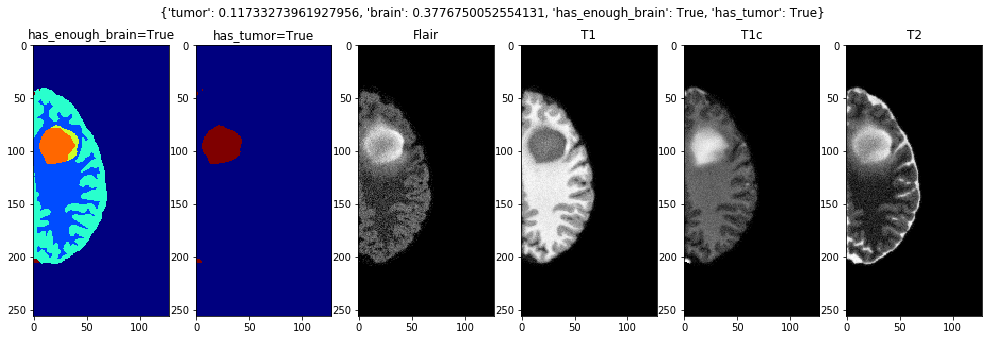

In [47]:
# Visualize a tumor sample
sample = 'HG0001'
slide = 104

label = labels[sample][slide]
fla = flair[sample][slide]
it1 = t1[sample][slide]
it1c = t1c[sample][slide]
it2 = t2[sample][slide]

met = get_labels(label)

plt.rcParams['figure.figsize'] = (17, 9)
fig, axarr = plt.subplots(1, 6)
axarr[0].imshow(label)
axarr[0].set_title('has_enough_brain=' + str(met['has_enough_brain']))
axarr[1].imshow(label > 2)
axarr[1].set_title('has_tumor=' + str(met['has_tumor']))
axarr[2].imshow(1.0 - fla, cmap='Greys')
axarr[2].set_title('Flair')
axarr[3].imshow(1.0 - it1, cmap='Greys')
axarr[3].set_title('T1')
axarr[4].imshow(1.0 - it1c, cmap='Greys')
axarr[4].set_title('T1c')
axarr[5].imshow(1.0 - it2, cmap='Greys')
axarr[5].set_title('T2')

fig.suptitle(met, y=0.77)
plt.show()


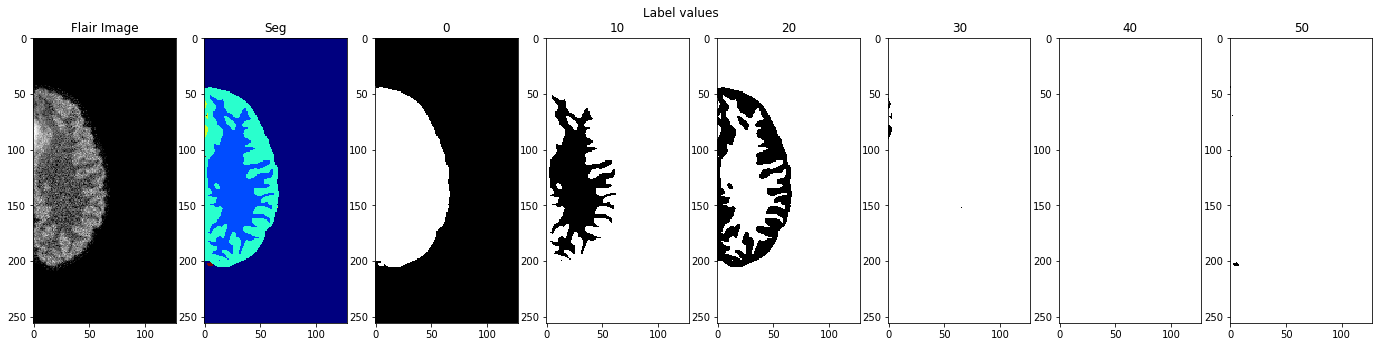

In [79]:
# Visualize a tumor sample
sample = 'HG0008'
slide = 106

label = labels[sample][slide]
fla = flair[sample][slide]
it1 = t1[sample][slide]
it1c = t1c[sample][slide]
it2 = t2[sample][slide]

met = get_labels(label)

plt.rcParams['figure.figsize'] = (24, 9)
fig, axarr = plt.subplots(1, 8)
axarr[0].imshow(1.0 - fla, cmap='Greys')
axarr[0].set_title("Flair Image")
axarr[1].imshow(label)
axarr[1].set_title("Seg")
axarr[2].imshow(label == 0, cmap='Greys')
axarr[2].set_title("0")
axarr[3].imshow(label == 1, cmap='Greys')
axarr[3].set_title("10")
axarr[4].imshow(label == 2, cmap='Greys')
axarr[4].set_title("20")
axarr[5].imshow(label == 3, cmap='Greys')
axarr[5].set_title("30")
axarr[6].imshow(label == 4, cmap='Greys')
axarr[6].set_title("40")
axarr[7].imshow(label == 5, cmap='Greys')
axarr[7].set_title("50")

fig.suptitle("Label values", y=0.77)
plt.show()


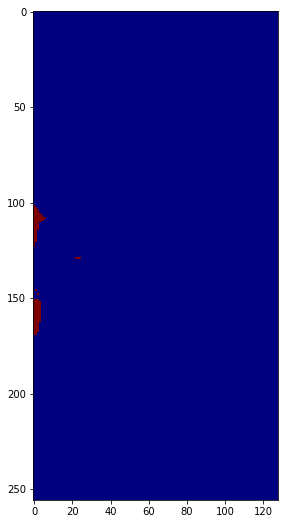

In [61]:
plt.imshow(labels['HG0001'][152] == 5)

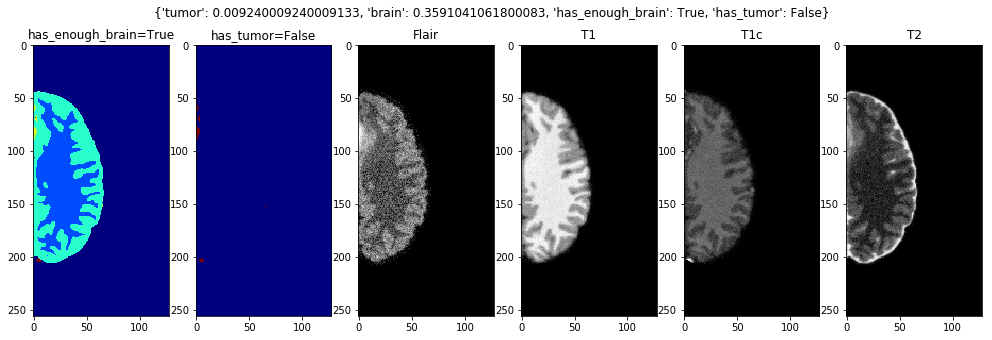

In [12]:
# Visualize a healthy sample
sample = 'HG0008'
slide = 106

label = labels[sample][slide]
fla = flair[sample][slide]
it1 = t1[sample][slide]
it1c = t1c[sample][slide]
it2 = t2[sample][slide]

met = get_labels(label)

plt.rcParams['figure.figsize'] = (17, 9)
fig, axarr = plt.subplots(1, 6)
axarr[0].imshow(label)
axarr[0].set_title('has_enough_brain=' + str(met['has_enough_brain']))
axarr[1].imshow(label > 2)
axarr[1].set_title('has_tumor=' + str(met['has_tumor']))
axarr[2].imshow(1.0 - fla, cmap='Greys')
axarr[2].set_title('Flair')
axarr[3].imshow(1.0 - it1, cmap='Greys')
axarr[3].set_title('T1')
axarr[4].imshow(1.0 - it1c, cmap='Greys')
axarr[4].set_title('T1c')
axarr[5].imshow(1.0 - it2, cmap='Greys')
axarr[5].set_title('T2')

fig.suptitle(met, y=0.77)
plt.show()

In [13]:
# Now create a dataframe and compute the label values
dataset = []
for sample in labels.keys():
    for slide in range(labels[sample].shape[0]):
        rightside = labels[sample][slide]
        met = get_labels(rightside)
        met['sample_name'] = sample
        met['slide'] = slide
        met['flair'] = flair[sample][slide]
        met['t1'] = t1[sample][slide]
        met['label'] = rightside
        met['label_img'] = labels_img[sample][slide]
        dataset.append(met)
stats = pd.DataFrame(dataset)


In [14]:
stats[stats.has_enough_brain].head(2)


,brain,flair,has_enough_brain,has_tumor,label,label_img,sample_name,slide,t1,tumor
47,0.306904,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",HG0018,47,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.269396
48,0.314611,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",HG0018,48,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.253889


In [15]:
# Select and study 20 random samples
tostudy = np.random.choice(stats['sample_name'].unique(), 20, replace=False)


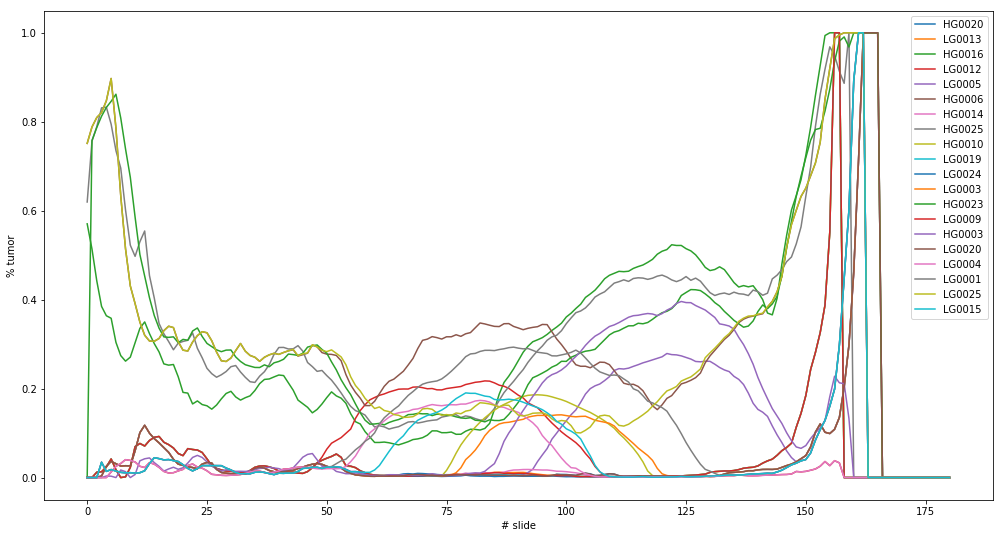

In [16]:
for sample in tostudy:
    plt.plot(
        stats[stats['sample_name'] == sample].slide,
        stats[stats['sample_name'] == sample].tumor,
        label=sample)
plt.xlabel('# slide')
plt.ylabel('% tumor')
plt.legend()
plt.show()


In [17]:
print 'Total image slices: ', stats.shape[0]


Total image slices:  9050


In [18]:
# Select slices with enough brain
base = stats[stats.has_enough_brain]
print 'Total image slices with enough brain:' , base.shape[0]


Total image slices with enough brain: 3540


In [19]:
print '# raw with tumor: ', Counter(base.has_tumor)[True]


# raw with tumor:  2472


In [20]:
# Split on patients so the classifier is not trained on people
# in the holdout set.
num_patients = base.sample_name.unique().shape[0]
print '# patients: ', num_patients
# Take the first 30 patients for training
train_pat = base.sample_name.unique()[:30]
# Take the remaining 20 patients for the holdout set
holdout_pat = base.sample_name.unique()[30:]


# patients:  50


In [29]:
train = base[base.sample_name.isin(train_pat)]
print 'Training patient id: ', train.sample_name.unique()


Training patient id:  ['HG0018' 'HG0019' 'HG0012' 'HG0013' 'HG0010' 'HG0011' 'HG0016' 'HG0017'
 'HG0014' 'HG0015' 'HG0023' 'HG0022' 'HG0021' 'LG0005' 'LG0004' 'LG0007'
 'LG0006' 'LG0001' 'LG0003' 'LG0002' 'LG0025' 'LG0024' 'LG0009' 'LG0022'
 'LG0021' 'LG0020' 'HG0009' 'HG0008' 'HG0002' 'HG0025']


In [30]:
holdout = base[base.sample_name.isin(holdout_pat)]
print 'Holdout patient id: ', holdout.sample_name.unique()


Holdout patient id:  ['HG0001' 'HG0003' 'HG0024' 'HG0005' 'HG0004' 'HG0007' 'HG0006' 'HG0020'
 'LG0023' 'LG0008' 'LG0016' 'LG0017' 'LG0014' 'LG0015' 'LG0012' 'LG0013'
 'LG0010' 'LG0011' 'LG0018' 'LG0019']


In [23]:
print '# training examples: ', train.shape[0]
print '# train raw with tumor: ', Counter(train.has_tumor)[True]

print '# holdout examples: ', holdout.shape[0]
print '# holtout raw with tumor: ', Counter(holdout.has_tumor)[True]


# training examples:  2125
# train raw with tumor:  1421
# holdout examples:  1415
# holtout raw with tumor:  1051


In [24]:
trainpath = path + "/train"
holdoutpath = path + "/holdout"

In [25]:
if not os.path.exists(trainpath):
    os.makedirs(trainpath + '/flair')
    os.makedirs(trainpath + '/segmentation')
    os.makedirs(trainpath + '/t1')

print trainpath

for i, row in train.iterrows():
    name = str(row['sample_name']) + '-' + str(row.slide) + '-' + str(row.has_tumor)
    imsave(trainpath + '/flair/' + name + '.png', row.flair)
    imsave(trainpath + '/t1/' + name + '.png', row.t1)
    imsave(trainpath + '/segmentation/' + name + '.png', row.label_img)


data/brats2013_tumor-notumor/train


In [26]:
if not os.path.exists(holdoutpath):
    os.makedirs(holdoutpath + '/flair')
    os.makedirs(holdoutpath + '/segmentation')
    os.makedirs(holdoutpath + '/t1')

print holdoutpath

for i, row in holdout.iterrows():
    name = str(row['sample_name']) + '-' + str(row.slide) + '-' + str(row.has_tumor)
    imsave(holdoutpath + '/flair/' + name + '.png', row.flair)
    imsave(holdoutpath + '/t1/' + name + '.png', row.t1)
    imsave(holdoutpath + '/segmentation/' + name + '.png', row.label_img)


data/brats2013_tumor-notumor/holdout


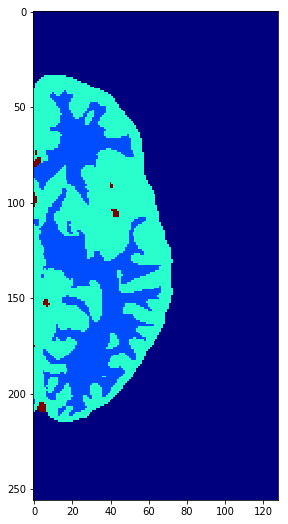

In [31]:
img_ = imread(
    'data/brats2013_tumor-notumor/train/segmentation/HG0017-71-False.png')
# Re-Scale between 0 and 1
img_ = img_.astype(np.float)

plt.imshow(img_)
plt.show()


In [32]:
# look at the values of the segmentation
print collections.Counter(img_.flatten())

Counter({0.0: 22393, 20.0: 6323, 10.0: 3974, 50.0: 78})


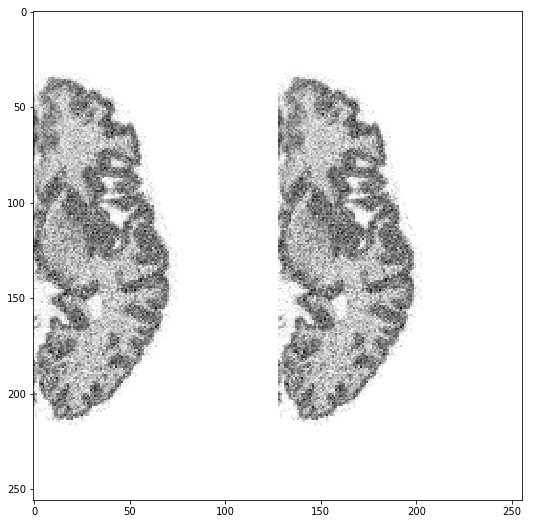

In [34]:
# Check that the images have been correctly recorded
# Visualize a sample

# Take a sample
img = train[(train.sample_name == "HG0017") &
                    (train.slide == 71)].flair.values[0]

# Load the image from the path
img_ = imread(
    'data/brats2013_tumor-notumor/train/flair/HG0017-71-False.png')
# Re-Scale between 0 and 1
img_ = img_.astype(np.float)

plt.imshow(np.concatenate([img, img_], axis=1), cmap='Greys')
plt.show()


In [35]:
#package files
!cd data && zip -rq brats2013_tumor-notumor.zip brats2013_tumor-notumor